In [ ]:
# loading the mnist dataset
import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data

# More importing common libraries

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import SGD, Adam
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [ ]:
import tensorflow as tf
# Set up the device
with tf.device('/GPU:0'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
cifar = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar.load_data()

# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = (x_train -127.5) / 127.5, (x_test-127.5) / 127.5

In [ ]:

print ("x_train.shape:" ,x_train.shape)
print ("x_test.shape:" ,x_test.shape)

x_train.shape: (50000, 32, 32, 3)
x_test.shape: (10000, 32, 32, 3)


In [ ]:

# Flatten the data
N, H, W, C = x_train.shape
D = H * W *C
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [ ]:

print ("x_train.shape:" ,x_train.shape)
print ("x_test.shape:" ,x_test.shape)

x_train.shape: (50000, 3072)
x_test.shape: (10000, 3072)


In [ ]:

# Dimensionality of the latent space
latent_dim = 100

In [ ]:

# Defining the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [ ]:

# Defining the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  
  model = Model(i, x)
  return model
     

In [ ]:
# Compile both models in preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile ( loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

In [ ]:
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1024)              5253

In [ ]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

z.shape

TensorShape([None, 100])

In [ ]:

# Pass noise through generator to get an image
img = generator(z)

In [ ]:
img

<KerasTensor: shape=(None, 3072) dtype=float32 (created by layer 'model_1')>

In [ ]:
# Make sure only the generator is trained
discriminator.trainable = False

In [ ]:

# The true output is fake, but we label them real!
# Passing the output of Generator to the Discriminator

fake_pred = discriminator(img)

In [ ]:
fake_pred

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'model')>

In [ ]:

# Create the combined model object
combined_model_gen = Model(z, fake_pred)

In [ ]:

# Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [ ]:
# Config

batch_size = 64
epochs = 20000
sample_period = 200 # every `sample_period` steps generate and save some data"
     

In [ ]:


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists("/content/drive/MyDrive/GAN's/Trial 2/gan_images"):
  os.makedirs("/content/drive/MyDrive/GAN's/Trial 2/gan_images")

In [ ]:
# A function to generate a grid of random samples from the generator and save them to a file

def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W,C))
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("/content/drive/MyDrive/GAN's/Trial 2/gan_images/%d.png" % epoch)
  plt.close()

In [ ]:
# generator.save("/content/drive/MyDrive/GAN's/Trial 2/generator.h5")

In [ ]:
# tf.keras.models.save_model()

In [ ]:

### Train the GAN

In [ ]:
# Main training loop
for epoch in range(epochs):

  ### Train discriminator 

  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  ### Train generator 

  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)
  

  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
epoch: 15101/20000, d_loss: 0.39,       d_acc: 0.84, g_loss: 1.54
2/2 [==============================] - 0s 10ms/step
epoch: 15201/20000, d_loss: 0.40,       d_acc: 0.79, g_loss: 1.78
2/2 [==============================] - 0s 15ms/step
epoch: 15301/20000, d_loss: 0.27,       d_acc: 0.89, g_loss: 2.48
2/2 [==============================] - 0s 11ms/step
epoch: 15401/20000, d_loss: 0.44,       d_acc: 0.77, g_loss: 2.75
2/2 [==============================] - 0s 10ms/step
epoch: 15501/20000, d_loss: 0.45,       d_acc: 0.75, g_loss: 2.02
2/2 [==============================] - 0s 12ms/step
epoch: 15601/20000, d_loss: 0.62,       d_acc: 0.73, g_loss: 2.13
2/2 [==============================] - 0s 6ms/step
epoch: 15701/20000, d_loss: 0.41,       d_acc: 0.84, g_loss: 2.04
2/2 [==============================] - 0s 12ms/step
epoch: 15801/20000, d_loss: 0.49,       d_acc: 0.76, g_loss: 2.04
2/2 [==

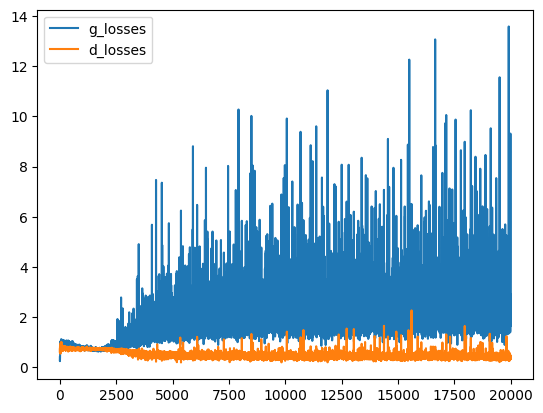

In [ ]:

plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [ ]:
generator.save("/content/drive/MyDrive/GAN's/Trial 2/generator/generator.h5")
discriminator.save("/content/drive/MyDrive/GAN's/Trial 2/discriminator/discriminator.h5")
combined_model_gen.save("/content/drive/MyDrive/GAN's/Trial 2/combined_model_gen/combined_model_gen.h5")

In [ ]:
generator.save("/content/drive/MyDrive/GAN's/Trial 2/generator/")
discriminator.save("/content/drive/MyDrive/GAN's/Trial 2/discriminator/")
combined_model_gen.save("/content/drive/MyDrive/GAN's/Trial 2/combined_model_gen/")

In [ ]:
idx = np.random.randint(0, 100, 15) # low-high-size
x_train[idx]

array([[-0.10588235, -0.06666667, -0.01960784, ...,  0.58431373,
         0.52941176,  0.46666667],
       [ 0.00392157,  0.10588235, -0.03529412, ...,  0.5372549 ,
         0.49019608,  0.14509804],
       [ 0.22352941,  0.52156863,  0.01176471, ...,  0.23137255,
         0.10588235, -0.0745098 ],
       ...,
       [ 0.22352941,  0.52156863,  0.01176471, ...,  0.23137255,
         0.10588235, -0.0745098 ],
       [-0.58431373, -0.49019608, -0.58431373, ..., -0.61568627,
        -0.60784314, -0.67843137],
       [ 0.27843137,  0.2627451 ,  0.01960784, ..., -0.23921569,
        -0.25490196, -0.23921569]])

In [ ]:
noise = np.random.randn(15, 100)
noise

array([[-0.52444125, -2.46347447,  0.6570941 , ...,  0.07105891,
         0.97978908, -0.49577864],
       [-1.66277908, -0.47540295,  0.33366443, ...,  0.31495909,
         1.12742881, -0.51279616],
       [-2.76853316, -0.88111498, -0.77575675, ...,  0.51201376,
         0.44525741, -0.06187261],
       ...,
       [ 0.27598905,  1.79461044,  1.44705108, ..., -1.35621464,
        -0.50478427,  0.022459  ],
       [-1.41243695, -0.47480985,  0.50611774, ...,  0.99727852,
        -1.74614961, -1.1791571 ],
       [ 0.98506471, -1.02144388,  0.15506878, ...,  1.83127259,
         0.93930989,  0.16598468]])

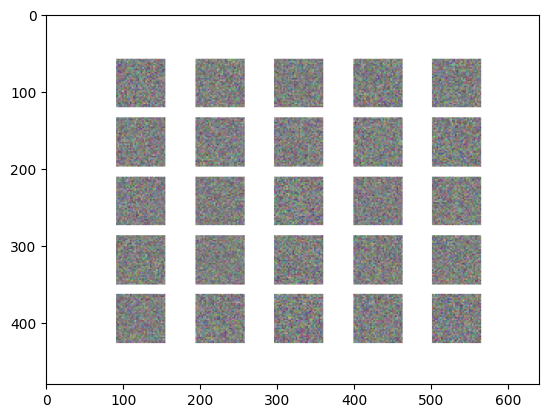

In [ ]:


from skimage.io import imread
a = imread("/content/drive/MyDrive/GAN's/Trial 2/gan_images/0.png")
plt.imshow(a)

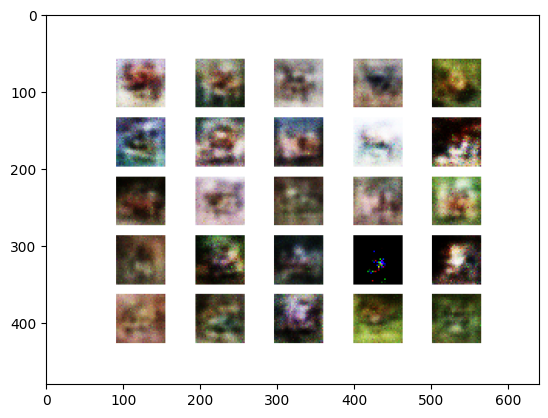

In [ ]:


from skimage.io import imread
a = imread("/content/drive/MyDrive/GAN's/Trial 2/gan_images/19800.png")
plt.imshow(a)

In [ ]:
#load the model

In [ ]:
GEN = load_model("/content/drive/MyDrive/GAN's/Trial 2/generator/generator.h5")

In [ ]:
DISC =load_model("/content/drive/MyDrive/GAN's/Trial 2/discriminator/discriminator.h5")

In [ ]:
COMBINED = load_model("/content/drive/MyDrive/GAN's/Trial 2/combined_model_gen/combined_model_gen.h5")

In [ ]:
# GEN1 = load_model("/content/drive/MyDrive/GAN's/Trial 2/generator/saved_model.pb")

In [ ]:
GEN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1024)              5253

In [ ]:
combined_model_gen.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_1 (Functional)        (None, 3072)              3838720   
                                                                 
 model (Functional)          (None, 1)                 1704961   
                                                                 
Total params: 5,543,681
Trainable params: 3,835,136
Non-trainable params: 1,708,545
_________________________________________________________________


Test Sample

In [ ]:
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
import tensorflow as tf

In [ ]:
#reshaping the image 

test_sample=[]
img=cv.imread("/content/drive/MyDrive/GAN's/Trial 2/test_rabbit.jpg")
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
img=cv.resize(img,(32,32))   
print(img.shape)         
test_sample.append(img)

(32, 32, 3)


In [ ]:
#Normalizing the data
test_sample = (test_sample[0] -127.5) / 127.5
test_sample

array([[[-0.98431373, -0.97647059, -0.99215686],
        [-0.89019608, -0.83529412, -0.96078431],
        [-0.57647059, -0.36470588, -0.78823529],
        ...,
        [-0.69411765, -0.51372549, -0.94509804],
        [-0.45098039, -0.23137255, -0.6627451 ],
        [-0.4745098 , -0.34117647, -0.71764706]],

       [[-0.96078431, -0.91372549, -0.98431373],
        [-0.94509804, -0.92156863, -0.97647059],
        [-0.61568627, -0.42745098, -0.81176471],
        ...,
        [-0.58431373, -0.56078431, -0.83529412],
        [-0.4745098 , -0.29411765, -0.65490196],
        [-0.34117647, -0.11372549, -0.63921569]],

       [[-0.55294118, -0.30980392, -0.71764706],
        [-0.90588235, -0.81960784, -0.99215686],
        [-0.74117647, -0.54509804, -0.86666667],
        ...,
        [-0.23921569, -0.16862745, -0.63137255],
        [-0.41960784, -0.28627451, -0.59215686],
        [-0.41176471, -0.19215686, -0.67843137]],

       ...,

       [[-0.16078431,  0.10588235, -0.57647059],
        [ 0

In [ ]:
# Flatten the data
H, W, C = test_sample.shape
D = H * W *C
test_image = test_sample.reshape(-1, D)
test_image

array([[-0.98431373, -0.97647059, -0.99215686, ...,  0.00392157,
         0.15294118, -0.41176471]])

In [ ]:
test_image.shape

(1, 3072)

In [ ]:
# Create an input to represent noise sample from latent space
latent_dim =100
z = Input(shape=(latent_dim,))

z.shape

TensorShape([None, 100])

In [ ]:
GEN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

TypeError: ignored

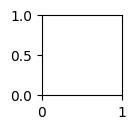

In [ ]:
generator = tf.saved_model.load('generator_model')

# Generate new images
noise = tf.random.normal([16, LATENT_DIM])
generated_images = generator(noise, training=False)
generated_images = (generated_images * 127.5) + 127.5
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i].numpy().astype('int'))
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 472ms/step


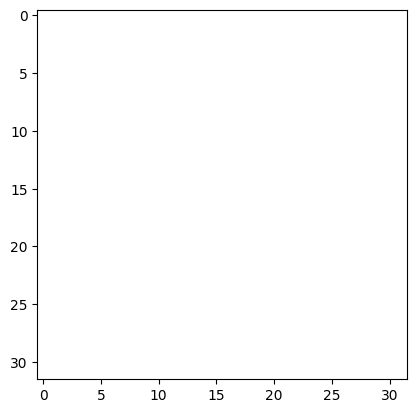

In [ ]:
# import tensorflow as tf
# import matplotlib.pyplot as plt

# # Load the saved GAN model
# gan_model = tf.keras.models.load_model("/content/drive/MyDrive/GAN's/Trial 2/generator/generator.h5")
# gan_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# # gan_model = tf.keras.models.load_model('saved_gan_model.h5')

# # Generate a random noise vector as input for the generator
# noise = tf.random.normal([1, 100])

# # Use the generator model to predict an image from the noise vector
# generated_image = gan_model.predict(noise)
# generated_image =generated_image.astype('float32')
# generated_image = (generated_image + 1) * 127.5

# # # Rescale the pixel values from [-1, 1] to [0, 255]
# # generated_image =  (generated_image*127.5) + 127.5
# image =generated_image[0].reshape(32,32,3)

# # Convert the generated image to a numpy array and plot it
# plt.imshow(image)
# plt.show()


In [ ]:
generated_image

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
generated_image.shape

(1, 3072)

In [ ]:
image =generated_image[0].reshape(-1,32,32,3)
image

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)

In [ ]:
noise_image = GEN.predict(noise)
noise_image.reshape(-1,32,32,3)
noise_image =  (noise_image*127.5) + 127.5
noise_image.reshape(-1,32,32,3).shape

1/1 [==============================] - 0s 26ms/step


(1, 32, 32, 3)

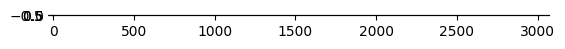

In [ ]:
plt.imshow(noise_image)
plt.show()

In [ ]:
# The true output is fake, but we label them real!
# Passing the output of Generator to the Discriminator
# Pass noise through generator to get an image
img = GEN(z)
fake_pred = DISC(img)
# # Create the combined model object
# combined_model_gen = Model(z, fake_pred)

In [ ]:
test_image[0][0]

-0.984313725490196

In [ ]:
# A function to generate a grid of random samples from the generator and save them to a file

def Sample_Images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = GEN.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W,C))
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("/content/drive/MyDrive/GAN's/Trial 2/Test_image/%d.png" % epoch)
  plt.close()

In [ ]:
real_imgs = test_image[0]

# Generate fake images
noise = np.random.randn(1, latent_dim)
fake_imgs = GEN.predict(noise)

DISC.predict(real_imgs)
DISC.predict(fake_imgs)
  

1/1 [==============================] - 0s 37ms/step


ValueError: ignored

In [ ]:
ones = np.ones(1)
zeros = np.zeros(1)
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  # idx = np.random.randint(0, x_train.shape[0])
  real_imgs = test_image[0]
  
  # Generate fake images
  noise = np.random.randn(1, latent_dim)
  fake_imgs = GEN.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = DISC.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = DISC.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(1, latent_dim)
  g_loss = COMBINED.train_on_batch(noise, ones)
  
  # # do it again!
  # noise = np.random.randn(1, latent_dim)
  # g_loss = combined_model_gen.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)

1/1 [==============================] - 0s 174ms/step


ValueError: ignored

In [ ]:
# ones = np.ones(1)
zeros = np.zeros(1)
zeros

array([0.])